# 02 Cat Dog

Throughout this notebook, we will walk through the journey to create a basic Vector search application using Vecto. The process is very similar to the previous tutorial, however we are adapting it to a new domain.

## Set Up Vecto Application

In [ ]:
!pip install ftfy tqdm requests pillow ipywidgets

In [ ]:
import requests
from ipywidgets import interact_manual, IntSlider, FileUpload
import pathlib
from IPython.display import Image, display
import math
from tqdm.notebook import tqdm
import io
import json

## Make a Vector Space

1. Access the Vecto login page at <[Vecto Login](https://app.vecto.ai/login.xhtml)>, insert your *Username* and *Password* and click Sign In. 
   
  2. From the admin page sidebar, select the **Dashboard** tab and click on *Create new vector space*. Fill in the Vector Space name; in this case, we will call it `cats_dogs`. You will then be able to choose a `vectorization model`. As we are going to work with both images and text, choose the [CLIP](https://github.com/openai/CLIP) model. Finally, click the `Create Vector Space` button. You can view your Vector Space details by clicking on the Vector Space name in the Vector Spaces list. Take note on your Vector Space ID to use in a later step. 
    
  3. In order to access the vector space, we will need to create a Vector Space authentication token. Click on the **Tokens** tab in the sidebar, set the token name to `cats_dogs_token`, and then select the Vector Space `cats_dogs` that we created earlier, click on `Create User Token`. Click on your token name in the list to view it. This token will be used to authenticate access to Vecto servers. Copy the token to use in the next step. Here we go! Now you have your first Vector Space.

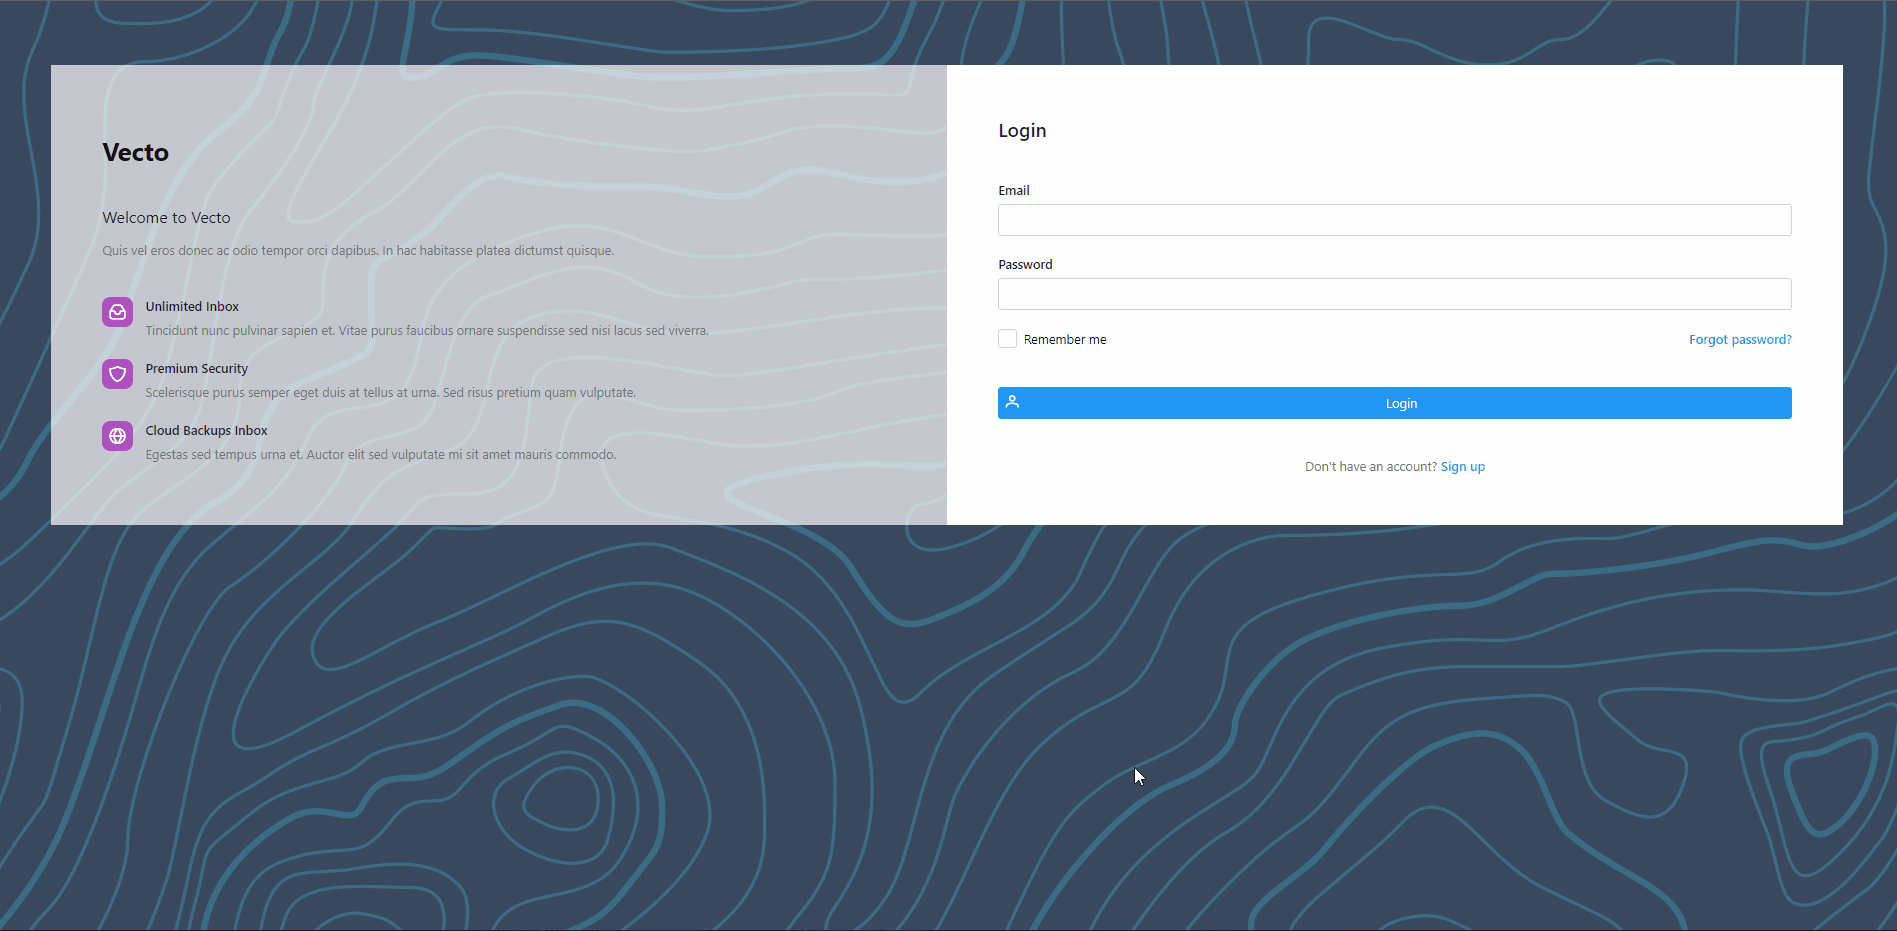

## Add and Ingest Data into Vector Space

To start, let's initialize the Vecto API end-point and pass our `cats_dogs` Vector Space ID and authentication token. Copy the below cell into your notebook 2nd cell and insert the values for the `token` and `vecto_space_id`, then run the cell:  

In [ ]:
vecto_base_url ="https://api.vecto.ai/api/v0"
token = ""
vector_space_id = ""

Please note that the Vector Space ID and token are unique for every Vector Space. You refer to the [previous step](#Make-a-Vector-Space) if you can not find your `cats_dogs` Vector Space ID or token. 

### Dataset

In this Tutorial, we are using the [Kaggle Cats and Dogs Dataset](https://www.microsoft.com/en-us/download/details.aspx?id=54765). This dataset has more than 25,000 `.jpg` images of cats and dogs. 

To proceed, you may manually download the dataset and place it in the working directory, or use Kaggle API to download it.

If you would like to use Kaggle, you may follow the [following steps](https://www.kaggle.com/general/74235):
1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens if you've created one before.
2. Click on Create New API Token - It will download kaggle.json file on your machine.
3. Place kaggle.json in the current Jupyter working directory.

In [ ]:
! pip install -q kaggle

In [ ]:
## run this cell if you are using google colab
# from google.colab import files
# files.upload()

In [ ]:
! mkdir .kaggle
! cp kaggle.json .kaggle/
! chmod 600 .kaggle/kaggle.json
! kaggle datasets download "shaunthesheep/microsoft-catsvsdogs-dataset"
! unzip microsoft-catsvsdogs-dataset.zip -d .

Now your working directory should look like this:
```
|__vecto_cat_dog_demo
    |__requirements.txt
    |__cat_dog_demo.ipynb
    |__PetImages
        |__Cat
            |__0.jpg
            |__1.jpg
            ...
        |__Dog
            |__0.jpg
            |__1.jpg
            ...
```
Now, let's set the path to our images in the notebook. First, let's find our base directory path and join it to our dataset folder. We use `list(dataset_path.glob('**/*.jpg'))` to collect all the images path in the dataset into a Python list.   

In [ ]:
base_dir = pathlib.Path().absolute()
dataset_path = base_dir.joinpath('PetImages')
pet_images = list(dataset_path.glob('**/*.jpg'))
print(pet_images[:5]) # print path to the first 5 image paths. 

### Ingest the Dataset

To ingest the images in the `pet_images` list into our `cats_dogs` Vector Space, we will need a few helper functions to split the image ingesting process into batches. Let's add the two functions `ingest_image_batch` and `ingest_all_images` to our `cat_dog_demo` notebook: 

In [ ]:
def ingest_image_batch(batch_path_list):
    data = {'vector_space_id': vector_space_id, 'data': [], 'modality': 'IMAGE'}
    files = []
    for path in batch_path_list:
        relative = "%s/%s" % (path.parent.name, path.name)
        data['data'].append(json.dumps(relative))
        files.append(open(path, 'rb'))
    
    results = requests.post("%s/index" % vecto_base_url,
                               data=data,
                               files=[('input', ('_', f, '_')) for f in files],
                               headers={"Authorization": "Bearer %s" %token})    
    print(results)
    for f in files:
        f.close()

In [ ]:
def ingest_all_images(path_list, batch_size=64):
    batch_count = math.ceil(len(path_list) / batch_size)
    batches = [path_list[i * batch_size: (i + 1) * batch_size] for i in range(batch_count)]
    for batch in tqdm(batches):
        ingest_image_batch(batch)

The batch size determines the number of images ingested in each batch. Here, we set the batch size to `128` to speed up the initial ingest process. However, batch size could be set to any other integer value, even just `1`, as this is merely depending on the dataset type and size. 

In [ ]:
ingest_all_images(path_list=pet_images, batch_size=128)

You will need to wait for the vectorization process to finish before moving to the next section.

## Vector Search image/text Queries

After ingesting the dataset into the `cats_dogs` vector space, now let's try to perform a different type of vector search query using text or images. For that, we will use a few helper functions to handle the mentioned processes. Let's add these four functions `display_results`, `lookup`, `text_query`, and 'image_query` to our `cat_dog_demo` notebook:

In [ ]:
def display_results(results):
    output = []
    for result in results:
        output.append("Similarity: %s" % result['similarity'])
        output.append(Image(dataset_path.joinpath(result['data'])))
    display(*output)

In [ ]:
def lookup(f, modality, top_k):
    result = requests.post("%s/lookup" % vecto_base_url,
                        data={'vector_space_id': vector_space_id, 'modality': modality, 'top_k': top_k},
                        files={'query': f},
                        headers={"Authorization":"Bearer %s" % token})

    results = result.json()['results']
    display_results(results)

In [ ]:
def text_query(query, top_k=10):
    f = io.StringIO(query)
    lookup(f, 'TEXT', top_k)

def image_query(query, top_k=10):
    f = io.BytesIO(query[0]['content'])
    lookup(f, 'IMAGE', top_k)

Now all is ready to try a few vector search queries!

First, let's start with some text queries. Using the interactive cell widget you could:
-  Type your query text in the available text box.
-  Select the number of results with the highest search similarity to view `top_k`.

For example, we will type *Kitten* as our text query and we expect the vector search to return kitten images from the vector space.

You are expected to see kittens when you query *Kitten* and set the *top_k* to 2, click the `Run Interact` button to start the vector search.

In [ ]:
interact_manual(text_query, query="Kitten", top_k=IntSlider(min=1, max=50))

Now similarly, let's try image queries. Using the interactive cell widget, you could:
-  Upload your query image using the Upload button.
-  Select the number of results with the highest search similarity to view `top_k`.

For example, we will upload a puppy photo as our image query, and we expect the vector search to return puppy images from the vector space when you click the `Run Interact` button to start the vector search.

In [ ]:
interact_manual(image_query, query=FileUpload(multiple=False), top_k=IntSlider(min=1, max=50))

## Create a Vector Search Analogy

A surprising property of vectors is that analogies can often be solved with vector arithmetic. Taking `dog is to puppy as a cat is to kitten` as an analogy, we could use the vector difference *puppy vector - dog vector* as an analogy vector to modify the vector search output for the *cat* query from returning images of cats as we saw in the *Part 2* above to returning images of kittens instead. The arithmetic equation that governs such an analogy can be represented as **puppy - dog + cat = kitten**.

To construct an analogy, you need three components:
1. The *start* of the analogy, in this example, is **Dog** 
2. The *end* of the analogy, in this example, is **Puppy**
3. The *query* to apply the analogy on, in this example, is **Cat**

Here, from the analogy *start* and *end* components, we can see the relation is Adult(dog) to Baby(puppy). Therefore we expect to get a kitten when we apply this analogy to the *Cat* query. Let's try that together:

First, let's add few helper functions to our notebook:

1. Apply analogy and perform the query vector search in vector space `analogy`.
2. Handler to apply text-based analogy `text_analogy`.
3. Handler to apply image-based analogy  `image_analogy`.


In [ ]:
def analogy(query, start, end, modality, top_k):
    
    result = requests.post("%s/analogy" % vecto_base_url,
                           data={'vector_space_id': vector_space_id, 'modality': modality, 'top_k': top_k},
                           files={'query': query, 'from': start, 'to': end},
                           headers={"Authorization":"Bearer %s" %token})
    
    results = result.json()['results']
    display_results(results)

In [ ]:
def text_analogy(query, start, end, top_k=10):
    analogy(io.StringIO(query), io.StringIO(start), io.StringIO(end), 'TEXT', top_k)

def image_analogy(query, start, end, top_k=10):
    analogy(
        io.BytesIO(query[0]['content']),
        io.BytesIO(start[0]['content']),
        io.BytesIO(end[0]['content']),
        'IMAGE',
        top_k
    )

Now all is ready, let's see if our analogy is working. 

First, let's start with some text analogy. Using the interactive cell widget, you could:
-  Type analogy *start*, *end* and query text in the available text boxes.
-  Select the number of results with the highest search similarity to view `top_k`.

Following our explained example, we will type *cat* as a query, *dog* as a start and *puppy* as an end.

In [ ]:
interact_manual(text_analogy, query="cat", start="dog", end="puppy", top_k=IntSlider(min=1, max=50))

You are expected to see kittens when you **query** is *cat* and set the analogy **start** and **end** to *dog* and *puppy*, respectively. Click the `Run Interact` button to start the vector search with the analogy.

Now similarly, let's construct the analogy using images.

Using the interactive cell widget, you could:
-  upload images for analogy *start*, *end* and query image using the upload button for each field.
-  Select the number of results with the highest search similarity to view `top_k`.

We will upload the *cat* image as a query, *dog* image as a start and *puppy* image as an end, and we expect the vector search to return kitten images from the vector space.  

In [ ]:
interact_manual(image_analogy, query=FileUpload(multiple=False), start=FileUpload(multiple=False), end=FileUpload(multiple=False), top_k=IntSlider(min=1, max=50))

Click the Run Interact button to start a vector search with the analogy.

In this tutorial, we have learned how to set up a Vecto working environment, create vector space using a given dataset, perform vector search queries, and construct a simple analogy.